```
Created on April 19, 2019
将来的なImpact Factor予測を行う
Impact Factorの定義
IF(f,y)=(Citation(f,y-1)+Citations(f,y-2))/(Publications(f,y-1)+Publications(f,y-2))

@author: ochi
```

In [34]:
import collections as cl
import codecs
import sys
import matplotlib

import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import os
import shutil
import csv
import random
import numpy as np
import sklearn.linear_model as slm
import sklearn.metrics as smt
import sklearn.metrics.pairwise as smp
import sklearn.neighbors as sn
import scipy.stats as ss
import seaborn as sns


In [35]:
def runAll():
#    cvs = [i for i in range(0,5,1)]
    cvs = [0]
#    iters = ["1000000","100000","10000","1000","100","10","1"]
    iters = ["10000"]
#    orders = ["1","2","joint"]
    orders = ["2"]
#    rhos = ["0.001","0.005","0.01","0.05","0.1","0.2","0.3","0.4","0.5"]
    rhos = ["0.2"]
    for cv in cvs:
        for order in orders:
            for itr in iters:
                for rho in rhos:
                    print("order:%s,iter:%s,rho:%s"%(order,itr,rho))
                    run(cv,order,itr,rho)
    return

In [36]:
def readSelectedAuthorsFile(filepath,delimiter=','):
    authors = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            authors.append(aid)

    return authors

In [37]:
def readLabeledFile(afile, delimiter=','):
    labelDic = {}
    with open(afile, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            label = row[1]
            labelDic[aid] = label

    return labelDic

In [38]:
def readVectorFilesJoint(vec_files, delimiter=' '):
    vecDics = []
    set_nodes = set([])
    for vec_file in vec_files:
        vecDic = readVectorFile(vec_file)
        vecDics.append(vecDic)
        if len(set_nodes) == 0:
            set_nodes = set(vecDic.keys())
        else:
            set_nodes &= set(vecDic.keys())

    m_vecDic = {}
    for node in list(set_nodes):
        new_vec = []
        for vecDic in vecDics:
            vec = vecDic[node]
            new_vec = np.append(new_vec,vec)

        m_vecDic[node] = new_vec

    return m_vecDic


In [39]:
def readVectorFile(vec_file, delimiter=' '):
    vecDic = {}
    with open(vec_file, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            if i == 0:
                # header line
                continue
            else:
                node = row[0]
                vec = np.array(row[1:-1],dtype=np.float)
                vecDic[node] = vec
            pass
    return vecDic

In [40]:
def makeMTXData(labelDic,vecDic,selected_authors,ref_aids=[]):
    xs = []
    ys = []
    vec_keys = set(vecDic.keys())
   
    selected_aids = []
    if len(ref_aids) == 0:
        aids = list(set(vecDic.keys())&set(labelDic.keys()))
    else:
        aids = ref_aids

    for i, aid in enumerate(aids):
        if aid not in vec_keys:
            continue

        selected_aids.append(aid)

        au_vec = vecDic[aid]
        distances = []
        label = labelDic[aid]
        for t_id in selected_authors:
            t_vec = vecDic[t_id]
#            distance = smp.cosine_distances([au_vec],[t_vec])[0,0]
            distance = smp.cosine_similarity([au_vec],[t_vec])[0,0]
            distances.append(distance)

#        a_x = distances
        # 近い順に並べてみる
        distances = sorted(distances, key=lambda x:-x)
        distances.append(float(label)) #特徴量に訓練させるラベルをまさかの追加
        a_x = distances
#        a_x = au_vec
        xs.append(a_x)
        y = int(labelDic[aid])
        ys.append(y)

    print("cos sim sorted")
    print(set(ys))
    y = np.array(ys, dtype=np.int).reshape((len(ys),1))
    print(y.shape)
    x = np.array(xs, dtype=np.float)
    print(x.shape)
    return x, y, selected_aids

In [41]:
def drawPRCMulti(yDic,probDic):

    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
#        print(name)
        probs = probDic[name]
        y     = yDic[name]
#        print(y)
#        print(set(probs))
#        precision, recall, thresholds = smt.precision_recall_curve(y,probs)
#        ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        if len(set(probs)) > 2:
            precision, recall, thresholds = smt.precision_recall_curve(y,probs)
            ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])
        else:
            precision = smt.precision_score(y,probs)
            recall    = smt.recall_score(y,probs)
            ax.step(recall, precision, 'x', color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        print(name)
        print("precision")
        print(precision)
        print("recall")
        print(recall)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title('h-index Prediction Precision-Recall Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("hindex_prediction_precision_recall_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [42]:
def printPRF(yDic,probDic,pths=[i/100.0 for i in range(100)]):
    for pth in pths:
        for label in probDic.keys():
            plabels = []
            for prob in probDic[label]:
                if prob >= pth:
                    plabels.append(1)
                else:
                    plabels.append(0)

            (precision, recall, fscore, support) = smt.precision_recall_fscore_support(yDic[label], plabels, average="binary")
            print("pth=%.2f,method=%s,%f,%f,%f"%(pth,label,precision,recall,fscore))

    return

In [43]:
def drawROCMulti(yDic,probDic):
    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
        print(name)
        probs = probDic[name]
        y     = yDic[name]
        
        if len(set(probs)) > 2:
            fpr, tpr, thresholds = smt.roc_curve(y, probs)
            auc = smt.auc(fpr, tpr)
            ax.step(fpr, tpr, color=palette[i%num_c], alpha=0.8, where='post', label="%s:%.3f"%(name,auc), lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("impactfactor_roc_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [94]:
cv=0
order='1'
#itr='1'
#rho='0.1'
itr='3000'
rho='0.05'
th="0.200000"

In [132]:
train_file   = "../../scopus_xml_scraper/csv01/top%sornot_impactfactor2013.csv"%(th)
test_file    = "../../scopus_xml_scraper/csv01/top%sornot_impactfactor2016.csv"%(th)
compare_results_file    = "../../scopus_xml_scraper/csv01/top%sornot_impactfactor2013.csv"%(th)

#selectedauthors_file = "../../scopus_xml_scraper/csv01/select1journals_impactfactor2009.csv"
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select10journals_impactfactor2009.csv"
selectedauthors_file = "../../scopus_xml_scraper/csv01/select100journals_impactfactor2009.csv"
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select1000journals_impactfactor2009.csv"
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select10000journals_impactfactor2009.csv"

if order == "joint":
    vectorfileDic = {
        "non_2009":[ "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%("1",itr,rho),
                     "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%("2",itr,rho),
                    ],
        "non_2013":[ "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%("1",itr,rho),
                     "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%("2",itr,rho),
                    ]
    }
else:
    vectorfileDic = {
#        "non_2009":"../res01sample_linkprd_new/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
#        "non_2013":"../res01sample_linkprd_new/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
#        "pre_2009":"../res01sample_linkprd_new/pre_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
#        "pre_2013":"../res01sample_linkprd_new/pre_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
#        "non_2009":"../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%(order,itr,rho),
#        "non_2013":"../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%(order,itr,rho),
    "non_2009":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
    "non_2013":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
    }


In [133]:
selected_authors = readSelectedAuthorsFile(selectedauthors_file)
train_labelDic = readLabeledFile(train_file)
test_labelDic  = readLabeledFile(test_file)
compare_labelDic = readLabeledFile(compare_results_file)


In [67]:
test_probDic={}
test_yDic={}
# print "Start: %s"%(a_mode)
if order == "joint":
    train_vec_files = vectorfileDic["non_2009"]
    train_vecDic = readVectorFilesJoint(train_vec_files)
else:
    train_vec_file = vectorfileDic["non_2009"]
#    train_vec_file = vectorfileDic["pre_2009"]
    train_vecDic = readVectorFile(train_vec_file)

print("complete getting train vectors")


complete getting train vectors


In [68]:
if order == "joint":
    test_vec_files = vectorfileDic["non_2013"]
    test_vecDic = readVectorFilesJoint(test_vec_files)
else:
    test_vec_file = vectorfileDic["non_2013"]
#    test_vec_file = vectorfileDic["pre_2013"]
    test_vecDic = readVectorFile(test_vec_file)

print("complete getting test vectors")

complete getting test vectors


In [134]:
train_aids = list(set(train_vecDic.keys())&set(train_labelDic.keys()))
test_aids  = list(set(test_vecDic.keys()) & set(test_labelDic.keys()) & set(compare_labelDic.keys()))
print(len(selected_authors))
selected_authors = list(set(train_aids)&set(test_aids)&set(selected_authors))
print(len(selected_authors))

200
97


In [135]:
train_x, train_y, train_aids =  makeMTXData(train_labelDic,train_vecDic,selected_authors,train_aids)
print("complete making train_xy")


cos sim sorted
{0, 1}
(1535, 1)
(1535, 98)
complete making train_xy


In [136]:
def getCompareResults(aids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for aid in aids:
        label = int(compare_labelDic[aid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [137]:
test_compare_res = getCompareResults(test_aids, compare_results_file)
comp_labelDic = {}
for i,aid in enumerate(test_aids):
    comp_labelDic[aid] = test_compare_res[i]
    
test_compare_res1 = []
for res in test_compare_res:
    if res == 0:
        n_res = 0.25
    else:
        n_res = 0.75
    n_res += (random.random()-0.5)/2.0
    test_compare_res1.append(n_res)


In [138]:
test_x,  compare_y,  test_aids  =  makeMTXData(compare_labelDic,test_vecDic,selected_authors,test_aids)

tys = []
for aid in test_aids:
    l = test_labelDic[aid]
    tys.append(l)
    
test_y = np.array(tys, dtype=np.int).reshape((len(tys),1))


print("complete making test_xy")


cos sim sorted
{0, 1}
(1055, 1)
(1055, 98)
complete making test_xy


In [139]:
model = slm.LogisticRegression(penalty='l2',tol=1e-6,C=1.0,warm_start=True)
model.fit(train_x, train_y)
print("complete lr model fit")
test_probs = model.predict_proba(test_x)[:,1]
print(test_probs)
print(test_y)
for i, p in enumerate(test_probs):
    if test_y[i][0] == 1:
        print("%s,prob:%f,y:%d"%(test_aids[i],p,test_y[i][0]))

print("complete lr model predict")

complete lr model fit
[ 0.01604271  0.01064832  0.01023744 ...,  0.98698054  0.01024387
  0.01346051]
[[0]
 [0]
 [0]
 ..., 
 [1]
 [0]
 [0]]
14599,prob:0.011644,y:1
18375,prob:0.975204,y:1
21100228564,prob:0.009759,y:1
4800152404,prob:0.010905,y:1
25332,prob:0.011044,y:1
17500155020,prob:0.973851,y:1
27959,prob:0.976663,y:1
12863,prob:0.977381,y:1
13332,prob:0.986529,y:1
23470,prob:0.973219,y:1
15300154827,prob:0.012740,y:1
21100203115,prob:0.009743,y:1
21100206268,prob:0.974100,y:1
21576,prob:0.979427,y:1
13688,prob:0.011829,y:1
18606,prob:0.013767,y:1
21100200805,prob:0.977774,y:1
24807,prob:0.011416,y:1
21100198432,prob:0.970848,y:1
13300154702,prob:0.978992,y:1
19600162011,prob:0.973679,y:1
17337,prob:0.010990,y:1
12284,prob:0.010959,y:1
24859,prob:0.011381,y:1
5700165152,prob:0.976095,y:1
27542,prob:0.976568,y:1
27540,prob:0.985997,y:1
21206,prob:0.979280,y:1
26512,prob:0.971853,y:1
24806,prob:0.009845,y:1
26969,prob:0.975595,y:1
11500153511,prob:0.983674,y:1
24242,prob:0.010313,y:

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [140]:
def getCompareResults(aids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for aid in aids:
        label = int(compare_labelDic[aid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [141]:
test_probDic["non_2013"] = test_probs
#test_probDic["pre_2013"] = test_probs
test_probDic["if2013"] = [float(ele) for ele in test_compare_res1]
test_yDic["non_2013"]    = test_y
#test_yDic["pre_2013"]    = test_y
test_yDic["if2013"]    = test_y
#print "model.coef_"
#print model.coef_


In [142]:
printPRF(test_yDic,test_probDic)


pth=0.00,method=non_2013,0.205687,1.000000,0.341195
pth=0.00,method=if2013,0.205687,1.000000,0.341195
pth=0.01,method=non_2013,0.227378,0.903226,0.363299
pth=0.01,method=if2013,0.206864,1.000000,0.342812
pth=0.02,method=non_2013,0.486111,0.645161,0.554455
pth=0.02,method=if2013,0.208333,0.990783,0.344275
pth=0.03,method=non_2013,0.486111,0.645161,0.554455
pth=0.03,method=if2013,0.209598,0.986175,0.345719
pth=0.04,method=non_2013,0.486111,0.645161,0.554455
pth=0.04,method=if2013,0.212724,0.986175,0.349959
pth=0.05,method=non_2013,0.486111,0.645161,0.554455
pth=0.05,method=if2013,0.214502,0.981567,0.352066
pth=0.06,method=non_2013,0.486111,0.645161,0.554455
pth=0.06,method=if2013,0.217791,0.981567,0.356485
pth=0.07,method=non_2013,0.486111,0.645161,0.554455
pth=0.07,method=if2013,0.218782,0.976959,0.357504
pth=0.08,method=non_2013,0.486111,0.645161,0.554455
pth=0.08,method=if2013,0.221757,0.976959,0.361466
pth=0.09,method=non_2013,0.486111,0.645161,0.554455
pth=0.09,method=if2013,0.22625

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [143]:
print(test_yDic.keys())
print(test_probDic.keys())

dict_keys(['non_2013', 'if2013'])
dict_keys(['non_2013', 'if2013'])


non_2013
precision
[ 0.20588235  0.20512821  0.20532319 ...,  1.          1.          1.        ]
recall
[ 1.          0.99539171  0.99539171 ...,  0.00921659  0.00460829  0.        ]
if2013
precision
[ 0.20865385  0.2078922   0.20809249 ...,  0.5         1.          1.        ]
recall
[ 1.          0.99539171  0.99539171 ...,  0.00460829  0.00460829  0.        ]


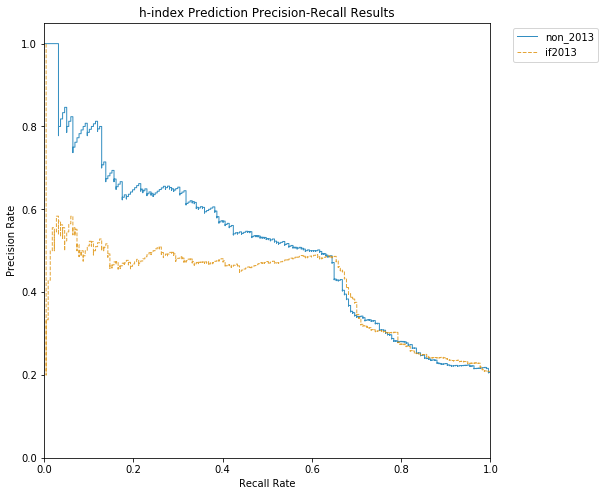

In [144]:
drawPRCMulti(test_yDic,test_probDic)

non_2013
if2013


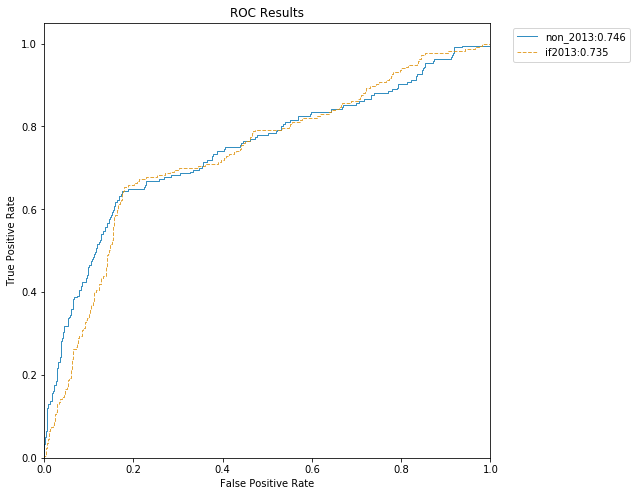

In [146]:
drawROCMulti(test_yDic,test_probDic)